In [1]:
import numpy as np
from scipy.misc import derivative
from scipy.optimize import minimize
from DFP import DFP
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import ticker
%matplotlib inline

*Для поэтапной отрисовки поиска оптимального решения запустить в каждом примере все блоки кода.Последний и будет тем, что надо*

# 8.	Метод послідовної безумовної оптимізації

### (метод Фіако і Мак-Кормика)

In [523]:
class SUO:
    """
        Sequential Unconstrained Optimization method that transform constraints into
        combined penalty function and perform unconstrained optimization

        Attributes
        ----------
        f (function): function that is optimized
        g (list(function)): list of inequality constraints
        h (list(function)): list of equality constraints
        beta (int): size of step that increases r
        eps (float): precision
        r (list(float)): penalty param
        y (list(tuple)): list of dots that were considered as optimal
        f_val (list(float)): list of f values in y
        n_iter (int): amount of iterations
        penalty_f_val (list(float)): value of penalty function in y
    """
    def __init__(self, f, g, h, beta=4, eps=1e-2):
        self.f = f
        self.g = list(g)
        self.h = list(h)
        self.beta = beta
        self.eps = eps
        self.r = [1.0]
        self.y = []
        self.f_val = []
        self.n_iter = 0
        self.penalty_f_val = []

    def get_penalty_function(self, x):
        """
            Creates penalty functions including each of constraint 
        :param x: dot of evaluation 
        :return: penalty function
        """
        penalty = 0

        for ineq_constraint in self.g:
            tmp = ineq_constraint(*x)
            if tmp < 0:
                penalty -= self.r[-1] * np.log(-ineq_constraint(*x))

        for eq_constraint in self.h:
            penalty += (1 / (self.r[-1] * 2)) * (eq_constraint(*x)**2)

        return penalty

    def opt_function(self, x):
        """
            Creates P-function that includes base function f and penalty function. Needed to
             perform unconstraied optimization
        :param x: dot
        :return: value of function
        """
        return self.f(*x) + self.get_penalty_function(x)

    def optimize(self, x0):
        """
            Main function to optimize
        :param x0: starting dot
        :return: optimal dot x_opt
        """
        self.y.append(x0)
        self.f_val.append(self.f(*x0))
        self.penalty_f_val.append(self.get_penalty_function(x0))
        opt_x = x0

        # пока занч по модолую штрафной фкнуции превосходит погрешность
        while np.abs(self.get_penalty_function(self.y[-1])) > self.eps:
            # Минимизируем безусловно комбинированую функцию
            dfp = DFP(self.opt_function, self.y[-1])
            # opt_x = dfp.solve()
            opt_x = minimize(self.opt_function, self.y[-1]).x

            # обновляем вес штрафного параметра и переходим дальше
            self.r.append(self.r[-1] / self.beta)
            self.y.append(opt_x)
            self.f_val.append(self.f(*opt_x))
            self.penalty_f_val.append(self.get_penalty_function(opt_x))
            self.n_iter += 1

        return opt_x

    def plot_contour(self):
        """
            Plot contour of main function. Also visualizes constraints 
        :return: None
        """
        x1 = np.arange(-100, 100, 10)
        x2 = np.arange(-100, 100, 10)
        x1, x2 = np.meshgrid(x1, x2)

        fs = self.f(x1, x2)
        gs = []
        hs = []
        for ineq in self.g:
            gs.append(ineq(x1, x2))
        for eq in self.h:
            hs.append(eq(x1, x2))

        fig = plt.figure(figsize=(25, 20))
        layout = (2, 2)
        ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
        ax2 = plt.subplot2grid(layout, (1, 0))
        ax3 = plt.subplot2grid(layout, (1, 1))

        locator = ticker.SymmetricalLogLocator(linthresh=0.1, base=2)
        lin_locator = ticker.LogitLocator()

        picture1 = ax1.contourf(x1, x2, fs, locator=locator)
        for g in gs:
            picture2 = ax1.contourf(x1, x2, g, locator=lin_locator, colors='black')
            picture2 = ax2.contourf(x1, x2, g, locator=lin_locator, colors='black')
        for h in hs:
            picture3 = ax1.contourf(x1, x2, h, locator=lin_locator, colors='red')
            picture3 = ax3.contourf(x1, x2, h, locator=lin_locator, colors='red')

        ax1.set_xlabel('x1', fontsize=20)
        ax1.set_ylabel('x2', fontsize=20)
        ax1.set_title('Main function', fontsize=25)

        ax2.set_xlabel('x1', fontsize=15)
        ax2.set_ylabel('x2', fontsize=15)
        ax2.set_title('Constraint g', fontsize=20)

        ax3.set_xlabel('x1', fontsize=15)
        ax3.set_ylabel('x2', fontsize=15)
        ax3.set_title('Constraint h', fontsize=20)

        plt.show();

    def plot_solution(self):
        """
            Plots contour of main function and its constraints. Also visualizes optimal dot
            and descent for it.
        :return: 
        """
        x1 = np.arange(-5, 5, 1)
        x2 = np.arange(-5, 5, 1)
        x1, x2 = np.meshgrid(x1, x2)

        fs = self.f(x1, x2)
        gs = []
        hs = []
        for ineq in self.g:
            gs.append(ineq(x1, x2))
        for eq in self.h:
            hs.append(eq(x1, x2))

        plt.figure(figsize=(25, 20))
        locator = ticker.SymmetricalLogLocator(linthresh=0.1, base=2)
        lin_locator = ticker.LogitLocator()

        picture1 = plt.contourf(x1, x2, fs, locator=locator)
        for g in gs:
            picture2 = plt.contourf(x1, x2, g, locator=lin_locator, colors='yellow')
        for h in hs:
            picture3 = plt.contourf(x1, x2, h, locator=lin_locator, colors='red')

        self.y = np.array(self.y)
        for i in range(1, len(self.y) - 1):
            plt.plot(self.y[i - 1:i + 1, 0], self.y[i - 1:i + 1, 1], color='black')
        plt.plot(self.y[-3:-1, 0], self.y[-3:-1, 1], color='black', label='Descent')

        plt.scatter(self.y[-1, 0], self.y[-1, 1], color='yellow', label='Solution')

        plt.legend(fontsize=14)
        plt.xlabel('x1', fontsize=20)
        plt.ylabel('x2', fontsize=20)
        plt.title('Solution', fontsize=25)
        plt.show();

    def stats(self):
        """
            Creates statistics report for each iteration/
        :return: pandas DataFrame
        """
        adder = {'k': '', 'rk': '', 'xk': '', 'f(xk)': '', 'P(xk, rk)': ''}

        cols = list(adder.keys())
        df = pd.DataFrame(columns=cols)
        for k in range(self.n_iter):

            adder['k'] = k
            adder['rk'] = self.r[k]
            adder['xk'] = self.y[k]
            adder['f(xk)'] = self.f_val[k]
            adder['P(xk, rk)'] = self.penalty_f_val[k]
            df = df.append(adder, ignore_index=True)
        return df

    def notebook_geom_process(self):
        """
            Function that can be called only from .ipynb.
            Demonstrates dynamic process of finding optimal dot 
        :return: 
        """
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(1, 1, 1)

        x1 = np.linspace(-2, 4)
        x2 = np.linspace(-2, 4)
        x1, x2 = np.meshgrid(x1, x2)

        fs = self.f(x1, x2)
        gs = []
        hs = []
        for ineq in self.g:
            gs.append(ineq(x1, x2))
        for eq in self.h:
            hs.append(eq(x1, x2))

        xs = np.array(self.y)

        locator = ticker.SymmetricalLogLocator(linthresh=0.1, base=2)
        lin_locator = ticker.LogitLocator()

        picture1 = plt.contourf(x1, x2, fs, locator=locator)
        for g in gs:
            picture2 = plt.contourf(x1, x2, g, locator=lin_locator, colors='yellow')
        for h in hs:
            picture3 = plt.contourf(x1, x2, h, locator=lin_locator, colors='red')
        ax.scatter(xs[-1, 0], xs[-1, 1], color='red')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        display(fig)

        clear_output(wait=True)
        plt.pause(0.5)

        for i in range(1, self.n_iter):
            ax.set_title('Iter: {}'.format(i), fontsize=25)
            ax.plot(xs[i - 1:i + 1, 0], xs[i - 1:i + 1, 1], color='black', linewidth=4)
            display(fig)

            clear_output(wait=True)
            plt.pause(0.3)

# Тести роботи програми

## Перший приклад

1. $f(x) = x_{1}^2 + x_{2}^2  \rightarrow min$  
$g(x) = x_{1} + x_{2} - 2 \le 0$  
$h(x) = x_{1} - 1 = 0$

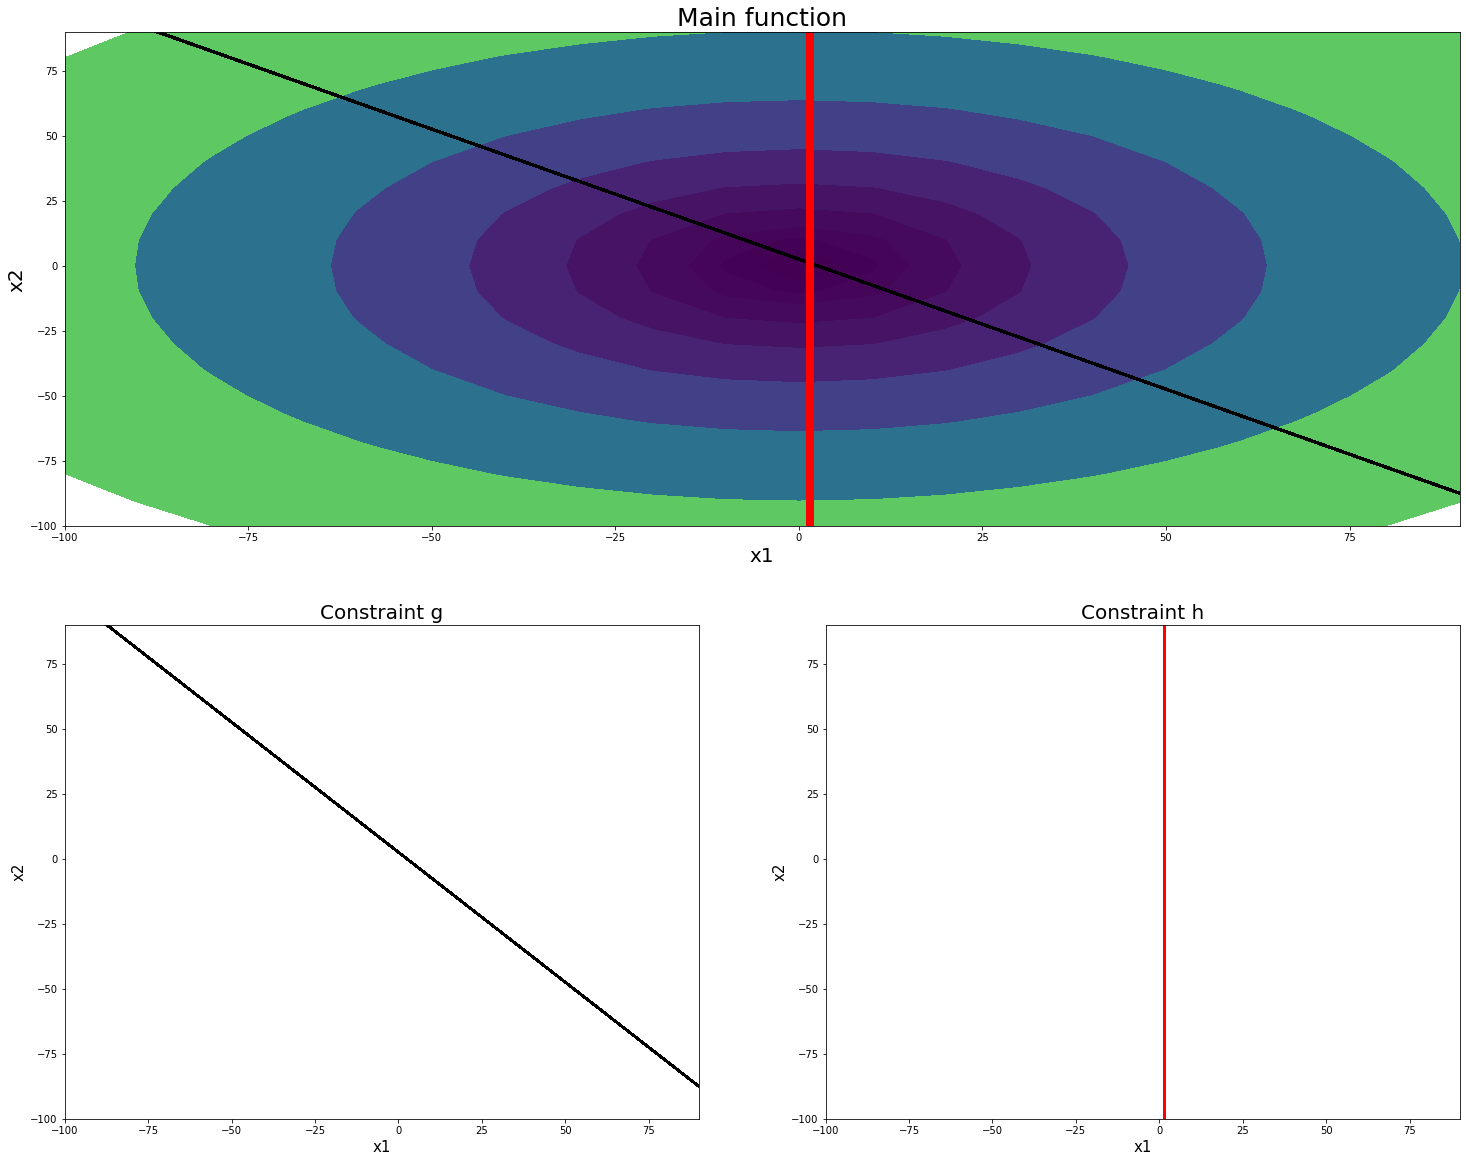

In [511]:
solver = SUO(lambda x1, x2: x1*x1 + x2*x2,
             [lambda x1, x2: x1 + x2 - 2],
             [lambda x1, x2: x1 - 1])
solver.plot_contour()

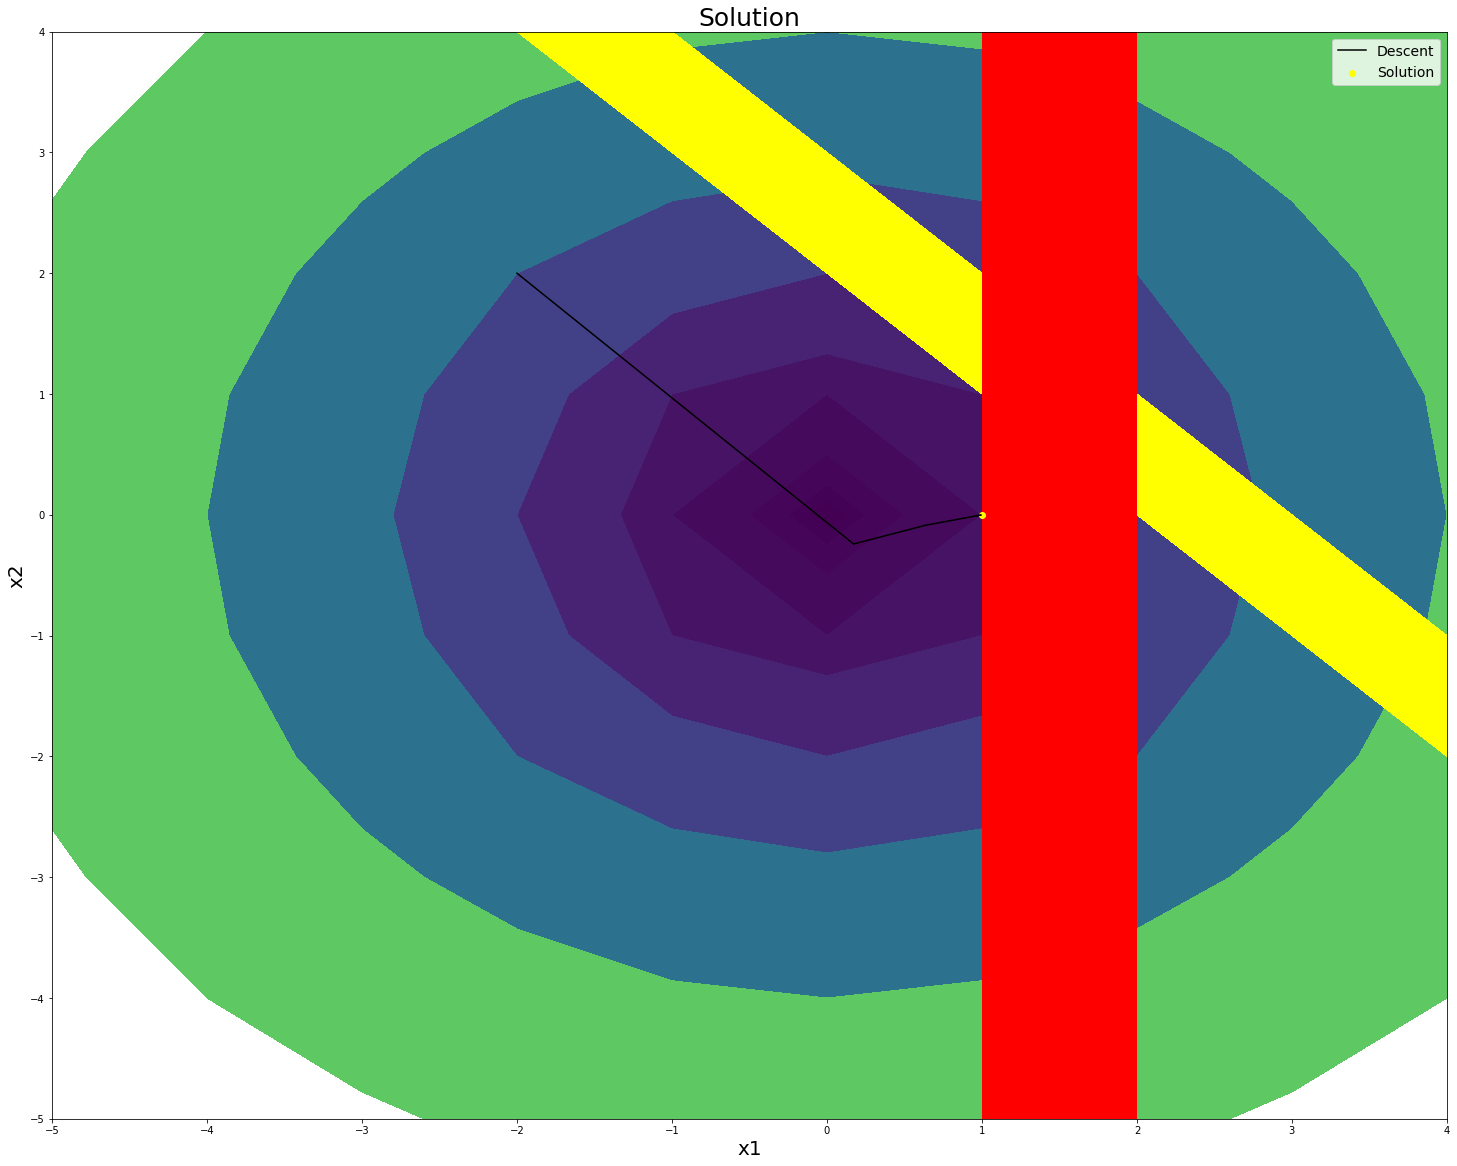

In [512]:
solver.optimize(x0=(-2, 2))
solver.plot_solution()

In [513]:
solver.stats()

,k,rk,xk,f(xk),"P(xk, rk)"
0,0,1.000000,"[-2.0, 2.0]",8,3.806853
1,1,0.250000,"[0.17225324673613754, -0.24161987997007264]",0.0880513,1.188519
2,2,0.062500,"[0.6378978838590427, -0.08630259020648777]",0.414362,1.025790
3,3,0.015625,"[0.8858471342192431, -0.0273756032119408]",0.785475,0.414920
4,4,0.003906,"[0.9694688976461492, -0.007526089106467971]",0.939927,0.119169
5,5,0.000977,"[0.9922330591617082, -0.001934363977792382]",0.98453,0.030877


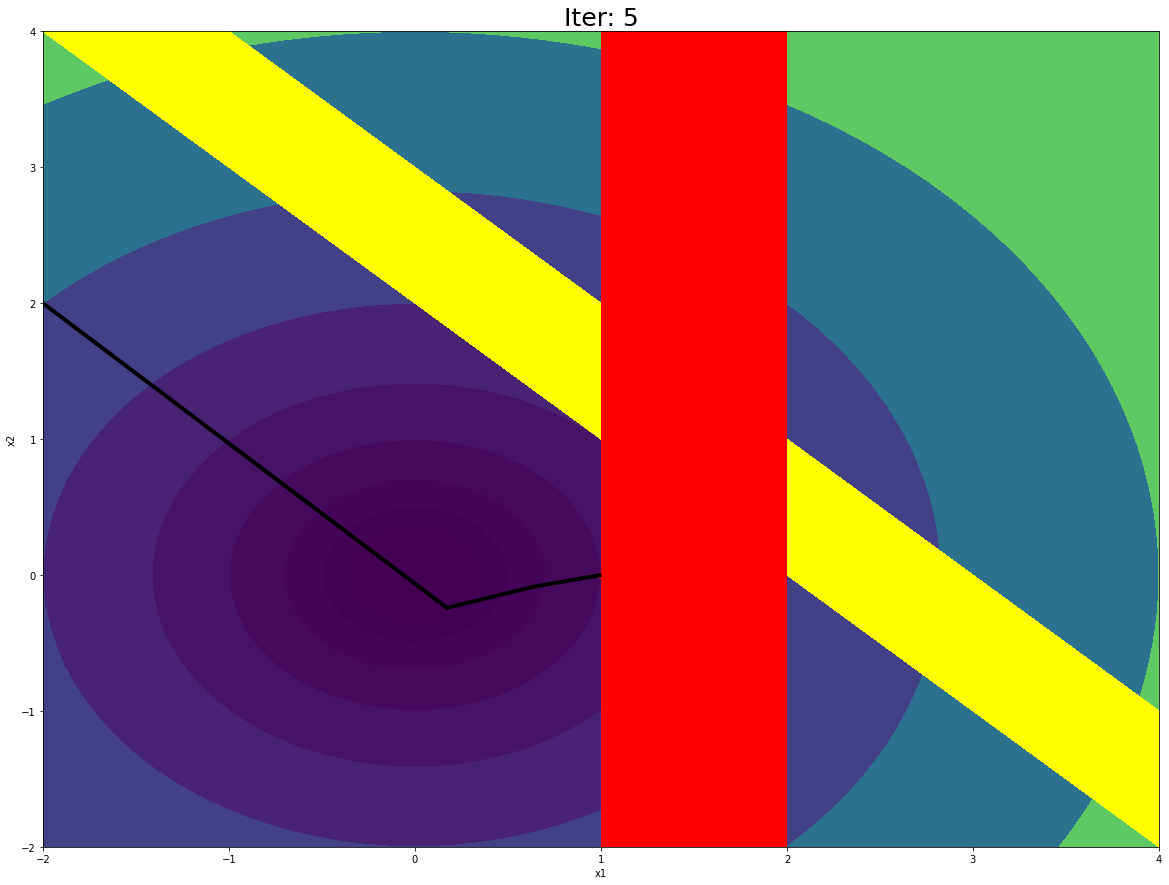

In [514]:
solver.notebook_geom_process()

## Другий приклад

2. $f(x) = \sqrt{x_{1}^2 + x_{2}^2}  \rightarrow min$  
$g(x) = -x_{1} \le 0$  
$h(x) = x_{1} + x_{2} - 2 = 0$

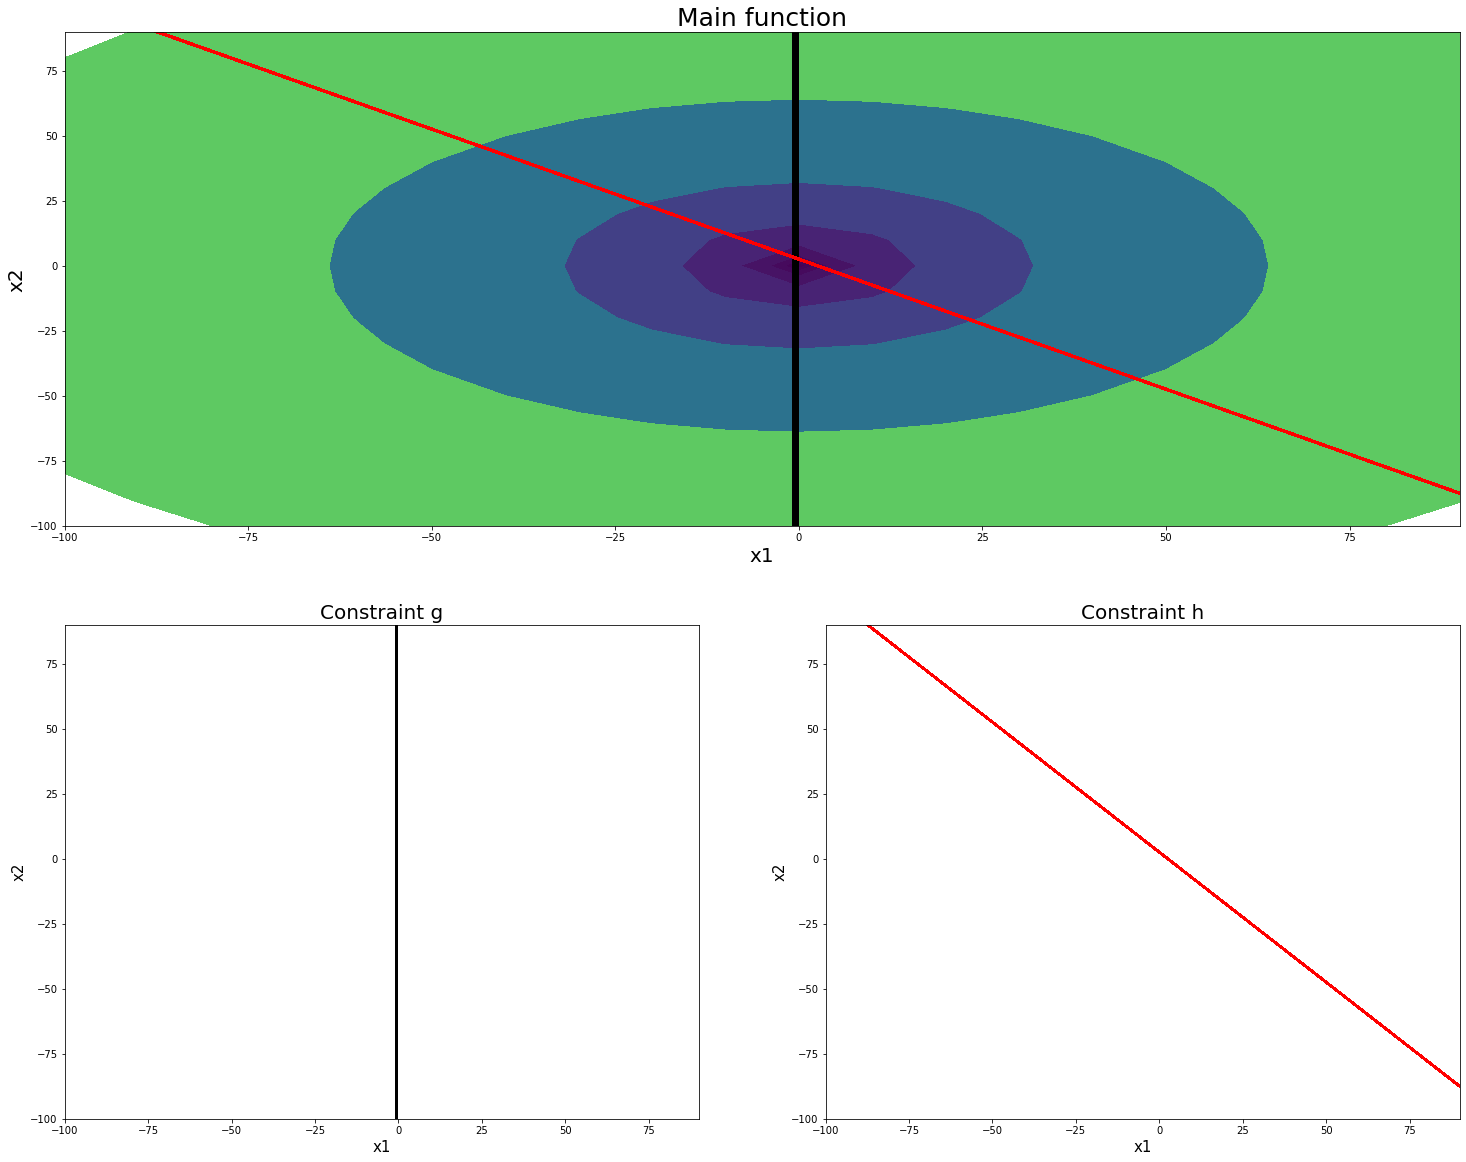

In [515]:
solver = SUO(lambda x1, x2: np.sqrt(x1**2 + x2**2),
             [lambda x1, x2: -x1],
             [lambda x1, x2: x1 + x2 - 2])
solver.plot_contour()

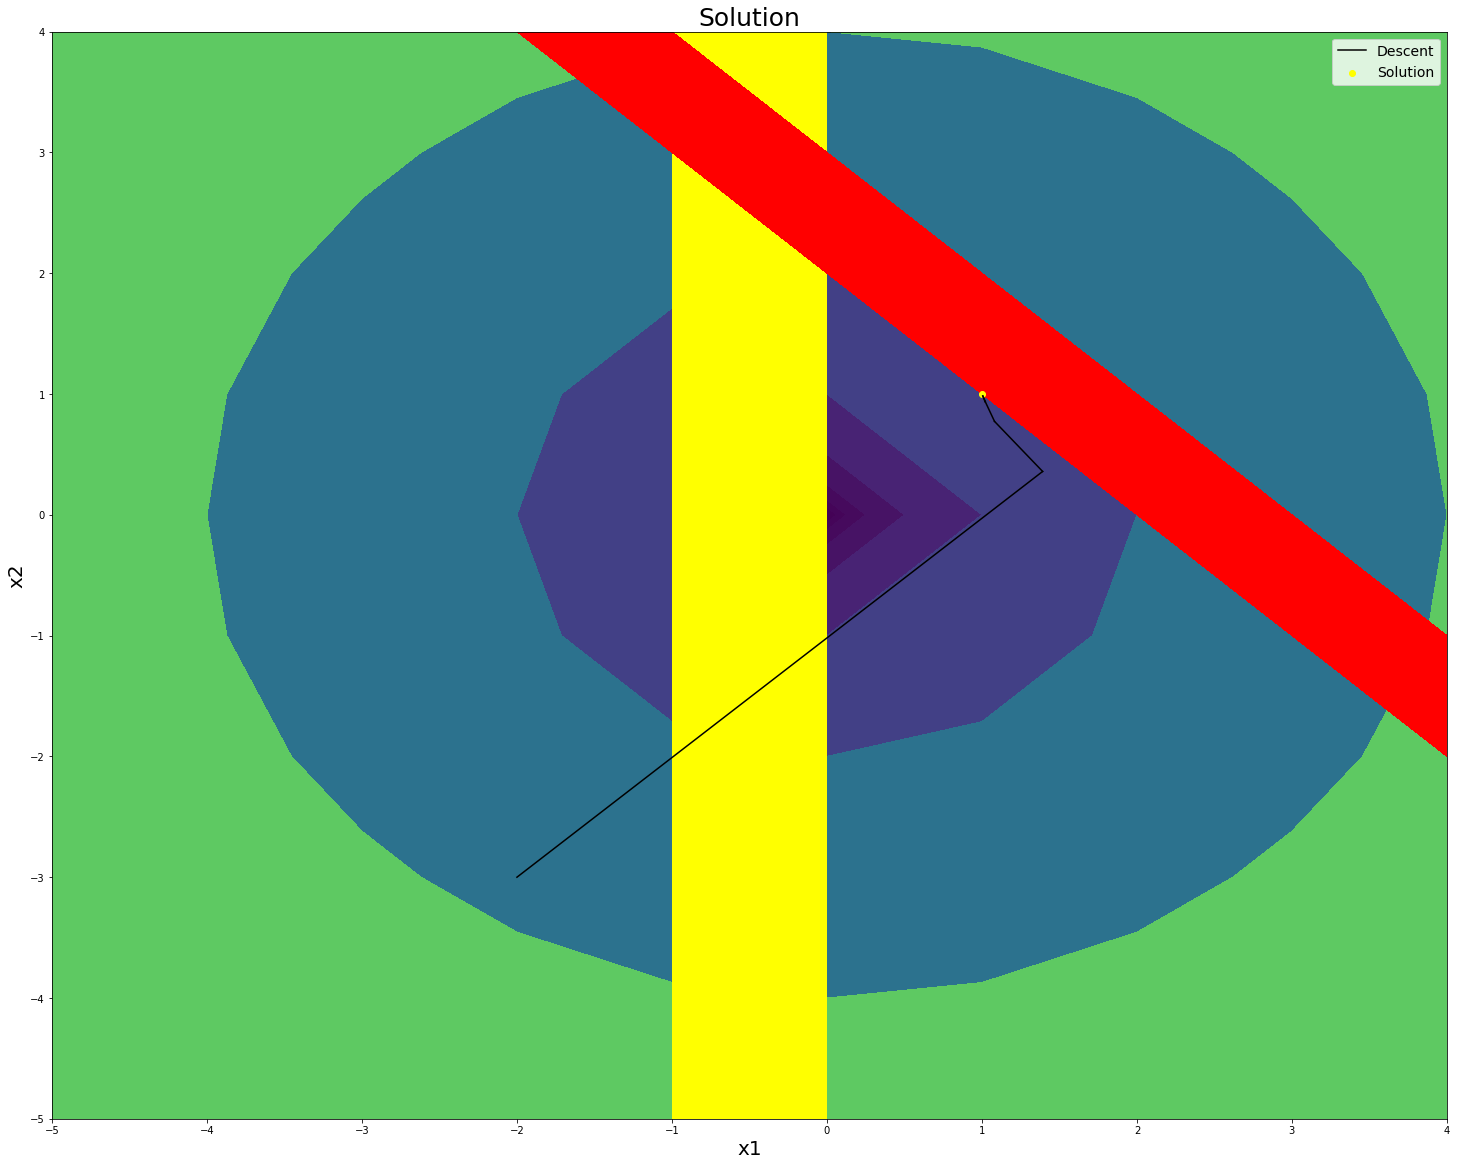

In [516]:
solver.optimize(x0=(-2, -3))
solver.plot_solution()

In [517]:
solver.stats()

,k,rk,xk,f(xk),"P(xk, rk)"
0,0,1.000000,"[-2.0, -3.0]",3.605551,24.500000
1,1,0.250000,"[1.3915111933775508, 0.3588077804496605]",1.437027,0.042084
2,2,0.062500,"[1.0809653022657155, 0.7735473003932591]",1.329233,0.164467
3,3,0.015625,"[1.0212813699040044, 0.9364786062250151]",1.385643,0.056766
4,4,0.003906,"[1.00546587419524, 0.9836076493650022]",1.406572,0.015260


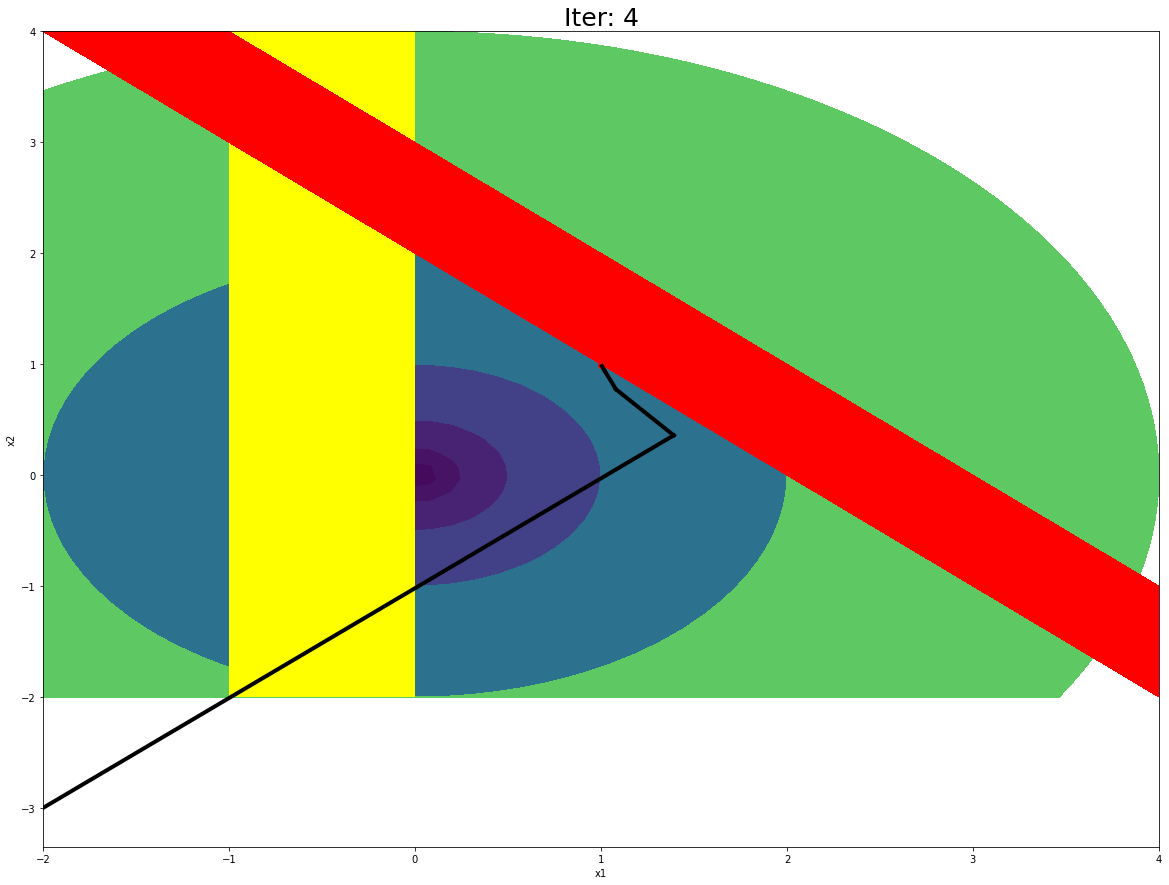

In [518]:
solver.notebook_geom_process()

## Третій приклад

3. $f(x) = e^{x_{1}} + e^{x_{2}}  \rightarrow min$  
$g_{1}(x) = -x_{1} -x2 + 1 \le 0$  
$g_{2}(x) = -x_{1} \le 0$  
$g_{3}(x) = -x2 \le 0$  
$h(x) = x_{1}^2 + x_{2}^2 - 9 = 0$

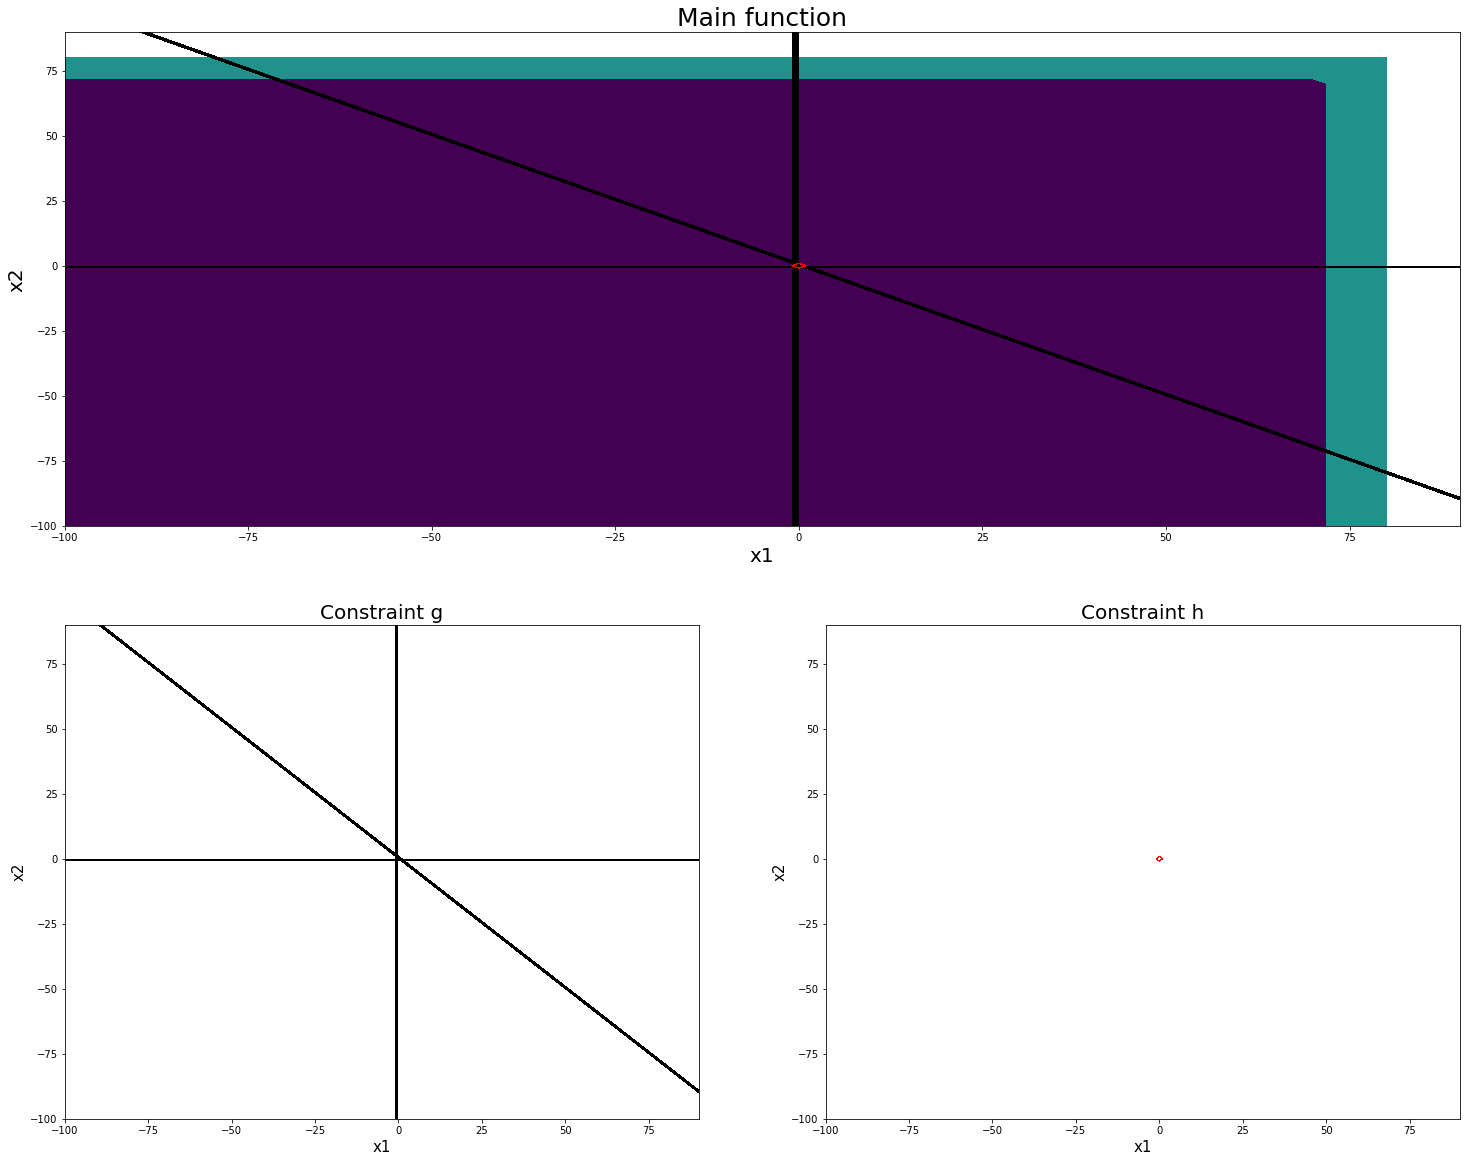

In [519]:
solver = SUO(lambda x1, x2: np.exp(x1) + np.exp(x2),
             [lambda x1, x2: -x1 - x2 + 1,
              lambda x1, x2: -x1,
              lambda x1, x2: -x2],
             [lambda x1, x2: x1*x1 + x2*x2 - 9])
solver.plot_contour()

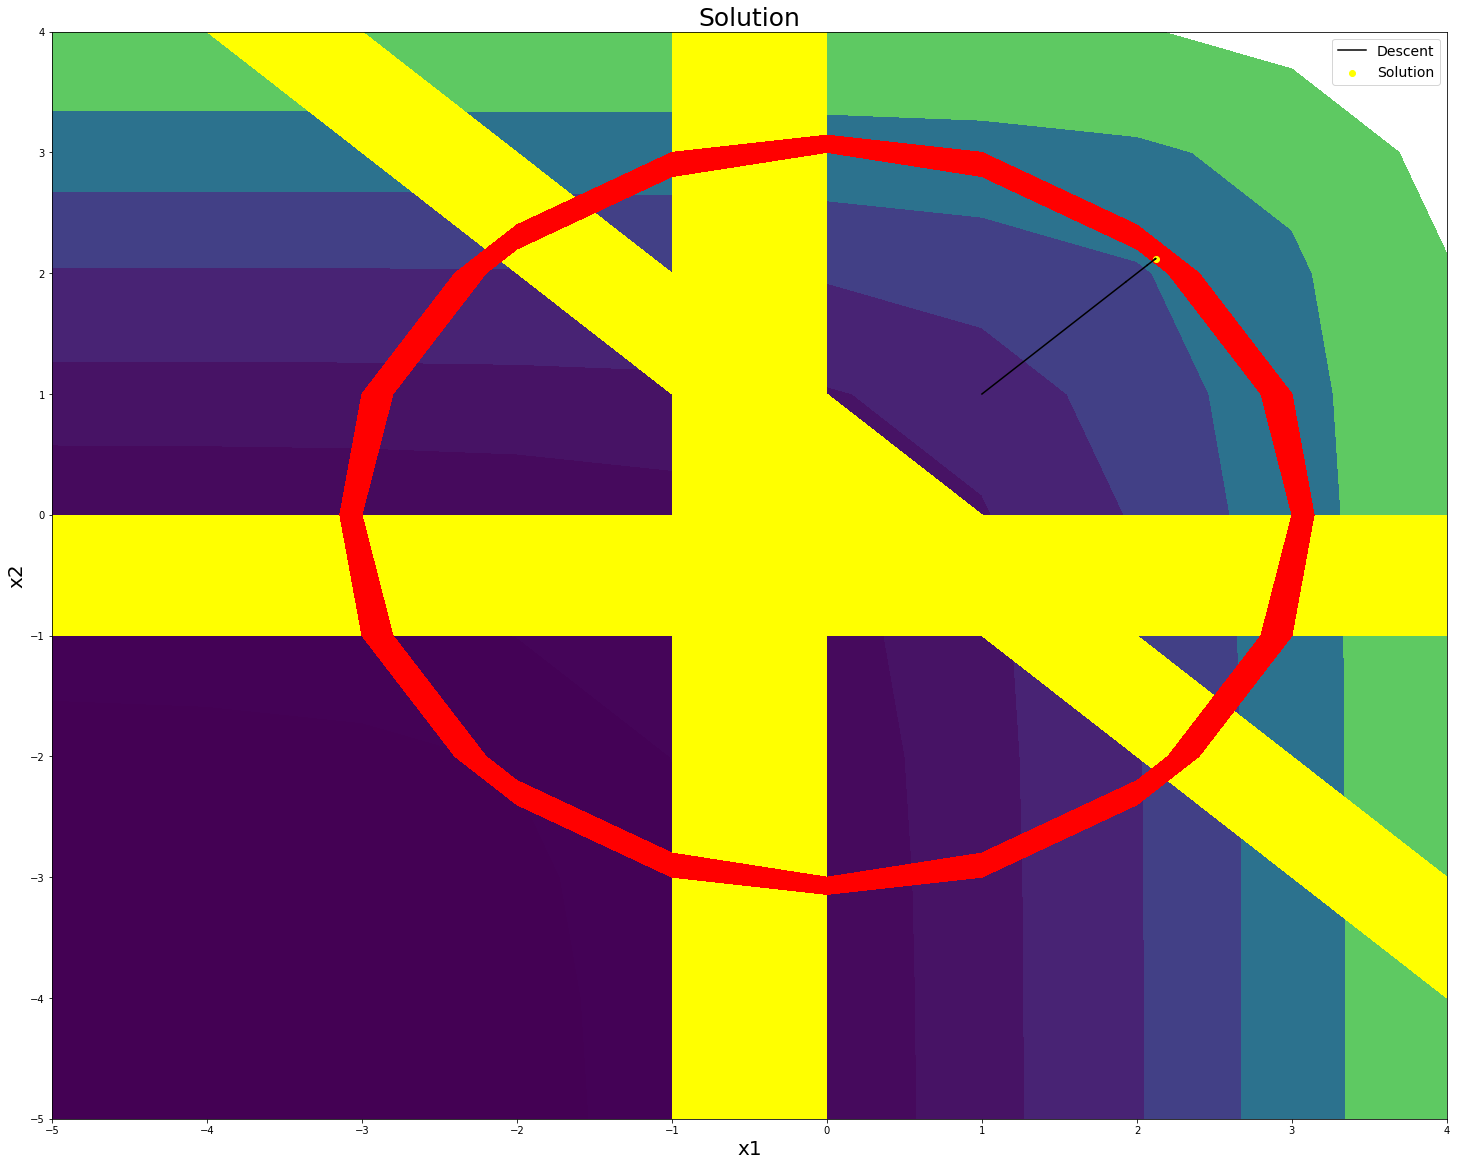

In [520]:
solver.optimize(x0=(1, 1))
solver.plot_solution()

In [521]:
solver.stats()

,k,rk,xk,f(xk),"P(xk, rk)"
0,0,1.000000,"[1.0, 1.0]",5.436564,24.500000
1,1,0.250000,"[1.9288859960351112, 1.9288859960351112]",13.763679,4.268718
2,2,0.062500,"[2.0657505405583896, 2.0657505405583896]",15.782437,1.570369
3,3,0.015625,"[2.1069838541420536, 2.1069838541420536]",16.446802,0.428826
4,4,0.003906,"[2.117708750678139, 2.117708750678139]",16.624141,0.109557
5,5,0.000977,"[2.1204157296378776, 2.1204157296378776]",16.669203,0.027538


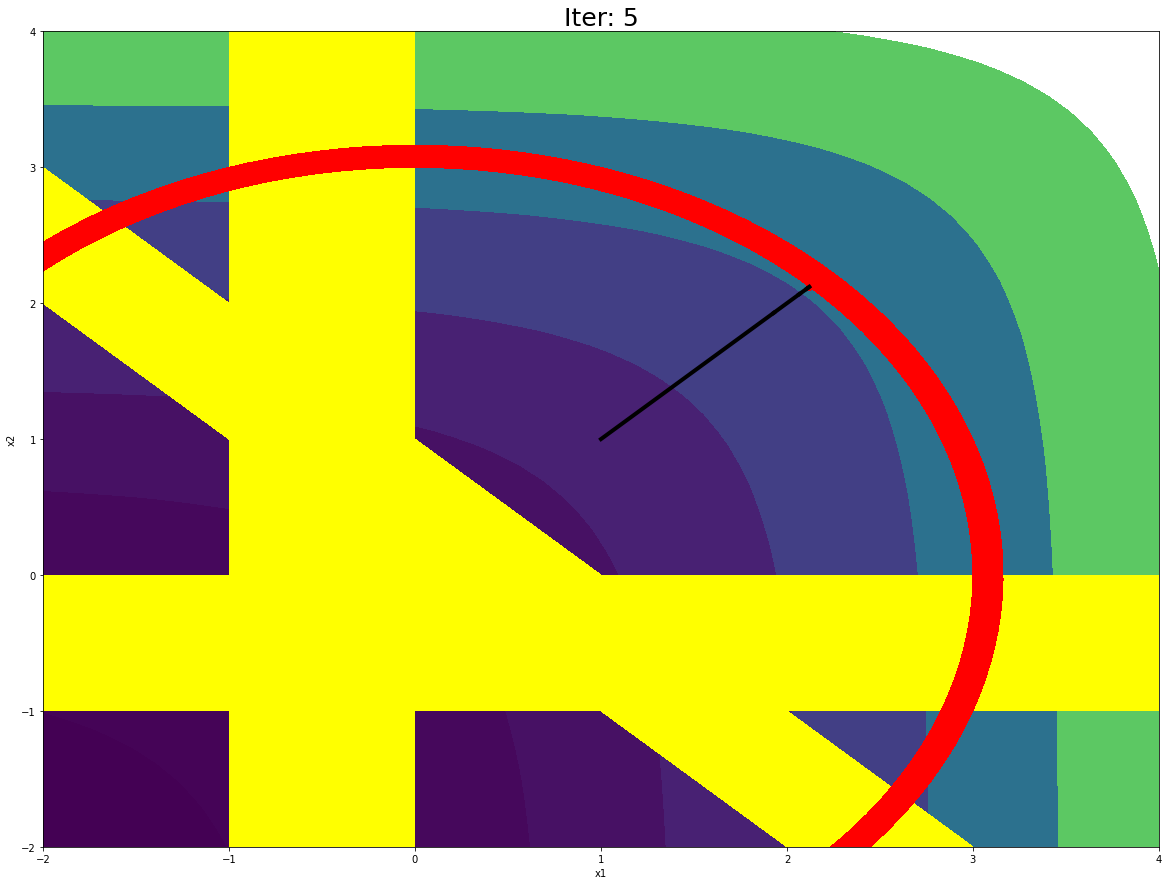

In [522]:
solver.notebook_geom_process()